<a href="https://colab.research.google.com/github/pooji0401/Text-Analysis/blob/master/ML_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pwd

/content


In [3]:
##imports
import re, string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [36]:
df_fake = pd.read_csv('data/Fake.csv',engine='python',error_bad_lines=False)
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [37]:
df_true = pd.read_csv('data/True.csv',engine='python',error_bad_lines=False)
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Data Preprocessing and Feature Engineering
Generally, for any predictive modelling task, before we fit our model  we clean our data -  remove nulls check for any class imbalance in the data.  </n>

For text analysis, each word (or combination of words) acts like feature, thereby resulting in <b> curse of dimensionality reduction </b>. Therefore, cleaning text is an essential step. There is no hard and fast rule about this process. It generally depends on the domain of the application. For example, in some cases, we completely convert the text to lower case where the Capitalisation doesn't play any major role. In the case of Spam words, where most of the text is captilised, Another interesting example in this scenario would be the punctuation marks. In most of the spam msgs, there are a lot of punctuation marks like '!','*',etc. Hence, there are various permutations of such techniques to clean the text. 

Interestingly, we can derive more features from text before preprocessing. This can include the count of specific punctuation marks, or even sentiment scores - polarity/subjectivity scores.

</n>

In this example, we are going to implement some basic preprocessing steps and establish a baseline for our analysis. 

### Checking for nulls

In [38]:
df_true.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [39]:
df_fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [40]:
df_fake['label'] = [1]*len(df_fake)
df_true['label'] = [0]*len(df_true)
df_fake['num_words'] = df_fake['text'].apply(lambda x: len(x.split()))
df_true['num_words'] = df_true['text'].apply(lambda x: len(x.split()))

### Checking for class imbalance and length imbalance

Length imbalance in this case refers to the significant difference in the length of means of both classes of examples. We want the model to work equally good with lengthy sentences for both classes. 

In order to balance out the lengths, we remove the extremes in both classes - above 75th percentile (too long sentences) and below 25th percentile(too short sentences).  

In [41]:
df_explore_words = pd.DataFrame(df_fake['num_words'].describe()).rename({'num_words':'fake_words'},axis=1)
df_explore_words['True_words'] = df_true['num_words'].describe()
df_explore_words

,fake_words,True_words
count,23481.000000,21417.000000
mean,423.197905,385.640099
std,408.388890,274.006204
min,0.000000,0.000000
25%,240.000000,148.000000
50%,363.000000,359.000000
75%,506.000000,525.000000
max,8135.000000,5172.000000


In [42]:
df_fake = df_fake[(df_fake['num_words']>=240)&(df_fake['num_words']<=506)]
df_true = df_true[(df_true['num_words']>=148)&(df_true['num_words']<=525)]
len(df_fake),len(df_true)

(11772, 10731)

In [43]:
df_total = pd.concat([df_fake,df_true],axis=0)
df_total.head()

,title,text,subject,date,label,num_words
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,305
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,420
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1,312


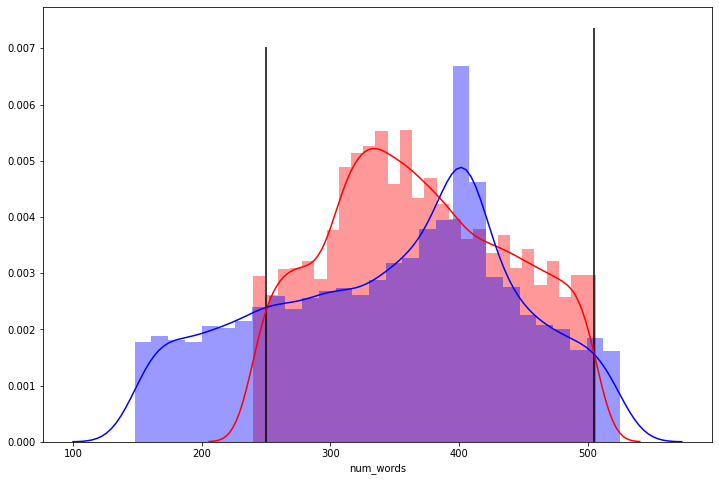

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
# plt.figure()
sns.distplot(df_total[df_total['label']==1]['num_words'],color='red')
sns.distplot(df_total[df_total['label']==0]['num_words'],color='blue')
ax.vlines(250,*ax.get_ylim())
ax.vlines(505,*ax.get_ylim())

We want to take the sequences with nearly same number of words in both the cases. As you can see, the common set of sentences have a range of 250 - 500 words.

In [45]:
df_total = df_total[(df_total['num_words']>=250)&(df_total['num_words']<=505)]

Finally, we rebalance the number of records across both the classes.

In [46]:
def rebalance_data(df):
    label_0_len = len(df[df['label']==0])
    label_1_len = len(df[df['label']==1])
    min_len = min(label_0_len,label_1_len)

    df_new_lab1 = df[df['label']==1].sample(min_len)
    df_new_lab0 = df[df['label']==0].sample(min_len)

    df=pd.concat([df_new_lab0,df_new_lab1])
    df.reset_index(inplace=True,drop=True)
    print('Total num of records after balancing ',len(df))
    return df

In [47]:
df_total = rebalance_data(df_total)

Total num of records after balancing  16428


In [48]:
df_total.label.value_counts()

1    8214
0    8214
Name: label, dtype: int64

In [49]:
df_total.head()

,title,text,subject,date,label,num_words
0,Palestinians may seek U.N. Assembly support if...,DUBAI (Reuters) - The Palestinian leadership m...,worldnews,"December 18, 2017",0,469
1,South Korea postpones university exam after ra...,SEOUL (Reuters) - South Korea postponed its an...,worldnews,"November 15, 2017",0,275
2,Puerto Rico's PREPA says will make full debt p...,SAN JUAN (Reuters) - Puerto Rico’s semi-public...,politicsNews,"June 30, 2016",0,412
3,Trump delays announcement on whether U.S. emba...,ABOARD AIR FORCE ONE (Reuters) - President Don...,politicsNews,"December 4, 2017",0,260
4,U.S. Senate panel approves controversial EPA n...,WASHINGTON (Reuters) - The Senate Environment ...,politicsNews,"October 25, 2017",0,329


In [50]:
df_final = df_total[['text','label']]
df_final.reset_index(drop=True,inplace=True)
df_final.head()

,text,label
0,DUBAI (Reuters) - The Palestinian leadership m...,0
1,SEOUL (Reuters) - South Korea postponed its an...,0
2,SAN JUAN (Reuters) - Puerto Rico’s semi-public...,0
3,ABOARD AIR FORCE ONE (Reuters) - President Don...,0
4,WASHINGTON (Reuters) - The Senate Environment ...,0


### Text Cleaning 
The steps followed for this step are as follows - 
1. Removing trailing white spaces
2. Removing punctuations
3. Removing stop words
4. Lemmatize the word to the verb level 
5. Removing all the proper nouns in the sentence using POS tagger
6. Converting the final filtered sentence to lower case

Note that, For step 5 (filtering nouns) Casing is very important in order to identify the nouns and any other tags. Therefore, it is the last step in our cleaning pipeline. Therefore, the order of these steps is also very important and specific to out application

In [51]:
def clean_lemma_text_blob(x):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    ## Removing Stop Words, Lemmatizing using Text Blob
    #     x = x.lower() ## Lower Case Conversion
    x = x.strip()
    x = regex.sub('', x) ## Removing Punctuations
    word_tokens = x.split()
    filtered_sentence = [Word(i.lower()).lemmatize("v") for i in word_tokens if not i in stop_words] 
    filtered_sentence = ' '.join(filtered_sentence)
    if(len(filtered_sentence.split())>0):
        p_blob = TextBlob(filtered_sentence)
        m = np.array(p_blob.tags)
#         m = m[(m[:,1]=='NN') | (m[:,1] =='JJ') | (m[:,1] =='VBP') | (m[:,1] =='VB') ]
        m = m[~(m[:,1]=='NN')]
        filtered_sentence = ' '.join(m[:,0])
        filtered_sentence = filtered_sentence.lower()
        return filtered_sentence
    else:
        return ''
    

In [52]:
def clean_text_df(df):
    df['text_noun_cleaned']=df['text'].apply(lambda x: clean_lemma_text_blob(x))
    return df

### Feature Engineering 

In this case, we are adding sentiment features - polarity and subjectivity scores using Text Blob package. 

<b>Polarity</b> indicates the tone of the sentence - postive, neutral and negative. The scores are in the range of [-1,+1]. <b>Subjectivity</b> indicates how the subject is addressed in the sentence. The scores are in the range [0,1]

Finally, we use the <b>Term-Frequency-Inverse-Document-Frequency TFIDF </b> to get the vectorised word features. Vectorization is the  process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or <b>“Bag of n-grams”</b>representation. This method also helps us in eliminating most frequent words and rarely occuring words from the corpus. 


Therefore, the document is defined by the occurences and co-occurences of words , thereby completely ignoring the order of their appearance or any meaning associated with the position of the word. 

For example, consider the following statement " Although he looks happy, he is actually not very happy about the performance of the model." A regular BOW model for sentiment classification would classify this statement to be positive because of the word "HAPPY" occuring twice in the statement. In reality, we know that this is not the case. 

However, it is a good approach to establish a baseline.




In [53]:
def get_sentiment_features(df):
    df['polarity']=df['text'].apply(lambda x:TextBlob(x).sentiment.polarity)
    df['subjectivity']=df['text'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
    return df

Combining the vectorised features with the sentiment features in a dataframe

In [82]:
## Retaining words (or combination of words) that occur in atleast 10% of documents or atmost 90% of documents
def data_transformation(df,tfidf_params = [0.1,0.9]):
    ## Tweaking parameters
    vectorizer = TfidfVectorizer(min_df=tfidf_params[0],max_df=tfidf_params[1],ngram_range=(1,2),stop_words={'english'})
    X = vectorizer.fit_transform(df['text_noun_cleaned'])
    df_input = pd.DataFrame(X.toarray())
    df_input.columns = vectorizer.get_feature_names()
    if 'label' in df.columns:
        df_input['label'] = df['label']
    df_input['polarity'] = df['polarity']
    df_input['subjectivity'] = df['subjectivity']
    return df_input, vectorizer

## Model Selection and Model Evaluation
In the following method, we try to fit multiple models - Bernoulli Naive Bayes, Random Forest Classifier, K-Nearest Neighbours and finally a Hard Voting Classifier using all the other mentioned classifiers.

We use accuracy to tune these models independently and search for the best Hyperparameters using Grid Search Cross Validation technique. 

In [56]:
def model_selection(df_input):
    results = {}
    l = list(df_input.columns)
    l.remove('label')
    X_train, X_test, y_train, y_test = train_test_split(df_input[l], df_input['label'],
                                                    test_size=0.33, random_state=42)
    
    ## BNB
    clf_bnb = BernoulliNB().fit(X_train, y_train)
    ypred=clf_bnb.predict(X_test)
    acc_BNB = accuracy_score(y_test,ypred)
    print("Accuracy for BNB model without any tuning: ", acc_BNB)
    results[clf_bnb] = acc_BNB
    
    ## Random Forest
    clf_rf = RandomForestClassifier(random_state=42)
    param_grid = [{ 
        'n_estimators': np.arange(10,110,10),
        'max_depth' : [4,5,6,7,8]
    }]
    CV_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv= 5)
    CV_rf.fit(X_train, y_train)
    y_pred = CV_rf.predict(X_test)
    acc_RF = accuracy_score(y_test,y_pred)
    print("Accuracy for Random Forest after CV: ", acc_RF)
    results[CV_rf] = acc_RF
    
    ## KNN
    clf_knn = KNeighborsClassifier()
    param_grid = [{ 
        'n_neighbors': np.arange(8,20)
    }]
    CV_knn= GridSearchCV(estimator=clf_knn, param_grid=param_grid, cv= 5)
    CV_knn.fit(X_train, y_train)
    y_pred = CV_knn.predict(X_test)
    acc_KNN = accuracy_score(y_test,y_pred)
    print("Accuracy for KNN after CV data: ",acc_KNN)
    results[CV_knn] = acc_KNN
    
    ## Voting Classifier
    eclf1 = VotingClassifier(estimators=[('nb', clf_bnb), ('rf', CV_rf), ('knn', CV_knn)], voting='hard')
    eclf1 = eclf1.fit(X_train, y_train)
    ypred = eclf1.predict(X_test)
    acc_VC = accuracy_score(y_test,ypred)
    print("Accuracy for voting classifier: ",acc_VC)
    results[eclf1] = acc_VC
    
    best_estimator = max(results, key=lambda k: results[k])
    return results,best_estimator
    

In [57]:
# def train_pipeline(df):
    ## Steps
    # 1.Reading files
#     df = read_files(filename)
    # 2. Checking for imbalance in data
#     df = rebalance_data(df)
    # 3. Text Cleaning 
    # df = clean_text_df(df)
    # # 4. Sentiment based features
    # df = get_sentiment_features(df)
    # # 5. Data Transformation
    # df_input,vect = data_transformation(df)
    # # 6. Model Selection 
    # trained_classifier = model_selection(df_input)
    # return trained_classifier, vect

In [58]:
# classifier,vect = train_pipeline(df_final)
df_final = clean_text_df(df_final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
df_final.head()

,text,label,text_noun_cleaned
0,DUBAI (Reuters) - The Palestinian leadership m...,0,reuters the palestinian may turn un general un...
1,SEOUL (Reuters) - South Korea postponed its an...,0,reuters south korea annual rare rattle shake b...
2,SAN JUAN (Reuters) - Puerto Rico’s semi-public...,0,san reuters puerto rico ’ semipublic know thur...
3,ABOARD AIR FORCE ONE (Reuters) - President Don...,0,aboard one reuters whether move us embassy jer...
4,WASHINGTON (Reuters) - The Senate Environment ...,0,reuters the senate public wednesday approve fo...


In [60]:
df_final = get_sentiment_features(df_final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
df_input,vect = data_transformation(df_final)

In [84]:
df_input.head()

,2016,add,allow,already,also,america,american,americans,among,and,another,appear,around,as,ask,back,become,believe,but,call,clear,close,come,continue,could,countries,days,democratic,democrats,do,donald,donald trump,earlier,even,every,expect,far,federal,find,first,...,set,several,show,since,speak,still,take,tell,that,the,there,they,think,this,though,three,thursday,top,trump,try,tuesday,two,unite,us,use,via,want,we,wednesday,well,whether,white,without,would,write,years,you,label,polarity,subjectivity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129412,0.0,0.000000,0.0,0.0,0.0,0.115007,0.0,0.0,0.0,0.096629,0.00000,0.000000,0.0,0.000000,0.0,0.084636,0.0,0.000000,0.0,0.0,0.000000,0.086278,0.107368,0.0,0.0,0.000000,0.120727,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.074256,0.000000,0.0,0.238552,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.128009,0.074342,0.0,0.0,0.000000,0.452424,0.340613,0.0,0.0,0.091971,0.088469,0.000000,0.108684,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0.021023,0.336553
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.126625,0.0,0.000000,0.0,0.185191,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.179039,0.0,0.000000,0.0,0.135203,...,0.0,0.0,0.0,0.000000,0.0,0.165845,0.110122,0.138325,0.0,0.353774,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.189198,0.0,0.0,0.0,0,0.083173,0.446154
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.182841,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.052054,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.065035,0.0,0.123484,0.0,0.000000,...,0.0,0.0,0.0,0.051059,0.0,0.000000,0.000000,0.000000,0.0,0.051403,0.0,0.000000,0.0,0.0,0.0,0.0,0.200227,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.073395,0.0,0.0,0.000000,0.000000,0.065654,0.058548,0.063208,0.000000,0.0,0.103089,0.0,0.0,0.0,0,0.035335,0.372081
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.138073,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.117927,0.00000,0.151614,0.0,0.104203,0.0,0.103290,0.0,0.152398,0.0,0.0,0.155167,0.000000,0.000000,0.0,0.0,0.152078,0.147336,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.231346,0.0,0.000000,0.000000,0.000000,0.0,0.116452,0.0,0.132737,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181454,0.0,0.0,0.000000,0.000000,0.332549,0.0,0.0,0.112241,0.000000,0.000000,0.000000,0.286393,0.239636,0.0,0.155696,0.0,0.0,0.0,0,0.001563,0.314583
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.15479,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.121499,0.151199,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.134374,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.104690,0.0,0.0,0.124757,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.171627,0.000000,0.000000,0.000000,0.0,0.089829,0.0,0.0,0.0,0,0.198684,0.437281


In [64]:
results,trained_classifier = model_selection(df_input)

Accuracy for BNB model without any tuning:  0.9850608631501291
Accuracy for Random Forest after CV:  0.9948358539284397
Accuracy for KNN after CV data:  0.883253412025083
Accuracy for voting classifier:  0.9878273699741793


Checking the feature importances of the best model - Random Forest Model

In [69]:
## Random Forest Estimator
rf_gridsearch_est = list(results.keys())[1]

In [79]:
df_feature_importances = pd.DataFrame()
l = list(df_input.columns)
l.remove('label')
df_feature_importances['Features'] = l
df_feature_importances['Feature Importances']=rf_gridsearch_est.best_estimator_.feature_importances_
df_feature_importances.sort_values(by='Feature Importances',ascending=False).head(10)

,Features,Feature Importances
109,reuters,0.395703
142,via,0.106189
112,say,0.081437
155,subjectivity,0.053683
69,like,0.031325
47,go,0.026954
126,the,0.025584
45,get,0.025356
9,and,0.019177
140,us,0.019168


In [85]:
df_feature_importances.sort_values(by='Feature Importances',ascending=False).tail(10)

,Features,Feature Importances
13,as,0.000180
20,clear,0.000177
119,show,0.000169
72,long,0.000168
67,least,0.000167
102,provide,0.000149
36,far,0.000139
61,kill,0.000139
98,open,0.000127
121,speak,0.000106


From the above list, the features with the highest feature importance show that informal words such as 'via', 